# Churn analysis on Iraninan telecom
## Problem: can we predict whether a customer will churn?

Source:  https://www.kaggle.com/royjafari/customer-churn
Data Set Information:

This dataset is randomly collected from an Iranian telecom companyâ€™s database over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns. The attributes that are in this dataset
are call failures, frequency of SMS, number of complaints, number of distinct calls, subscription length, age group, the charge amount, type of service, seconds of use, status, frequency of use, and Customer Value.

All of the attributes except for attribute churn is the aggregated data of the first 9 months. The churn labels are the state of the customers at the end of 12 months. The three months is the designated planning gap.

Toolkit
* Logistic Regression
* k-Nearest Neighbors
* Decision Trees
* Support Vector Machine
* Naive Bayes

Attribute Information:

* Anonymous Customer ID
* Call Failures: number of call failures
* Complains: binary (0: No complaint, 1: complaint)
* Subscription Length: total months of subscription
* Charge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)
* Seconds of Use: total seconds of calls
* Frequency of use: total number of calls
* Frequency of SMS: total number of text messages
* Distinct Called Numbers: total number of distinct phone calls
* Age Group: ordinal attribute (1: younger age, 5: older age)
* Tariff Plan: binary (1: Pay as you go, 2: contractual)
* Status: binary (1: active, 2: non-active)
* Churn: binary (1: churn, 0: non-churn) - Class label
* Customer Value: The calculated value of customer
* FP: number of False Positives
* FN: count of False Negatives

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')


In [4]:
#read in data
churn = pd.read_csv('./data/Customer_Churn.csv')


In [5]:
churn.head(5)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


In [75]:
churn.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
FN                         0
FP                         0
Churn                      0
dtype: int64

In [6]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  FN                       3150 non-null   float64
 14  FP                      

In [13]:
#Count of people that churned
churn.Churn.value_counts()  # of the total, % churn is about 15.7%

0    2655
1     495
Name: Churn, dtype: int64

In [23]:
#Count of people that are still active. Status of 1 = active
churn.Status.value_counts() 


1    2368
2     782
Name: Status, dtype: int64

In [8]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
Call Failure,3150.0,7.627937,7.263886,0.0,1.000000,6.000,12.000000,36.000
Complains,3150.0,0.076508,0.265851,0.0,0.000000,0.000,0.000000,1.000
Subscription Length,3150.0,32.541905,8.573482,3.0,30.000000,35.000,38.000000,47.000
Charge Amount,3150.0,0.942857,1.521072,0.0,0.000000,0.000,1.000000,10.000
Seconds of Use,3150.0,4472.459683,4197.908687,0.0,1391.250000,2990.000,6478.250000,17090.000
Frequency of use,3150.0,69.460635,57.413308,0.0,27.000000,54.000,95.000000,255.000
Frequency of SMS,3150.0,73.174921,112.237560,0.0,6.000000,21.000,87.000000,522.000
Distinct Called Numbers,3150.0,23.509841,17.217337,0.0,10.000000,21.000,34.000000,97.000
Age Group,3150.0,2.826032,0.892555,1.0,2.000000,3.000,3.000000,5.000
Tariff Plan,3150.0,1.077778,0.267864,1.0,1.000000,1.000,1.000000,2.000


<AxesSubplot:>

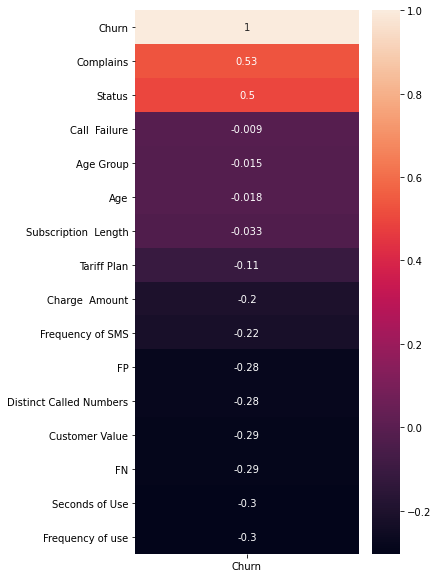

In [10]:
#heatmap
plt.figure (figsize=(5,10));
sns.heatmap(churn.corr()[['Churn']].sort_values(by='Churn', ascending = False),annot=True )

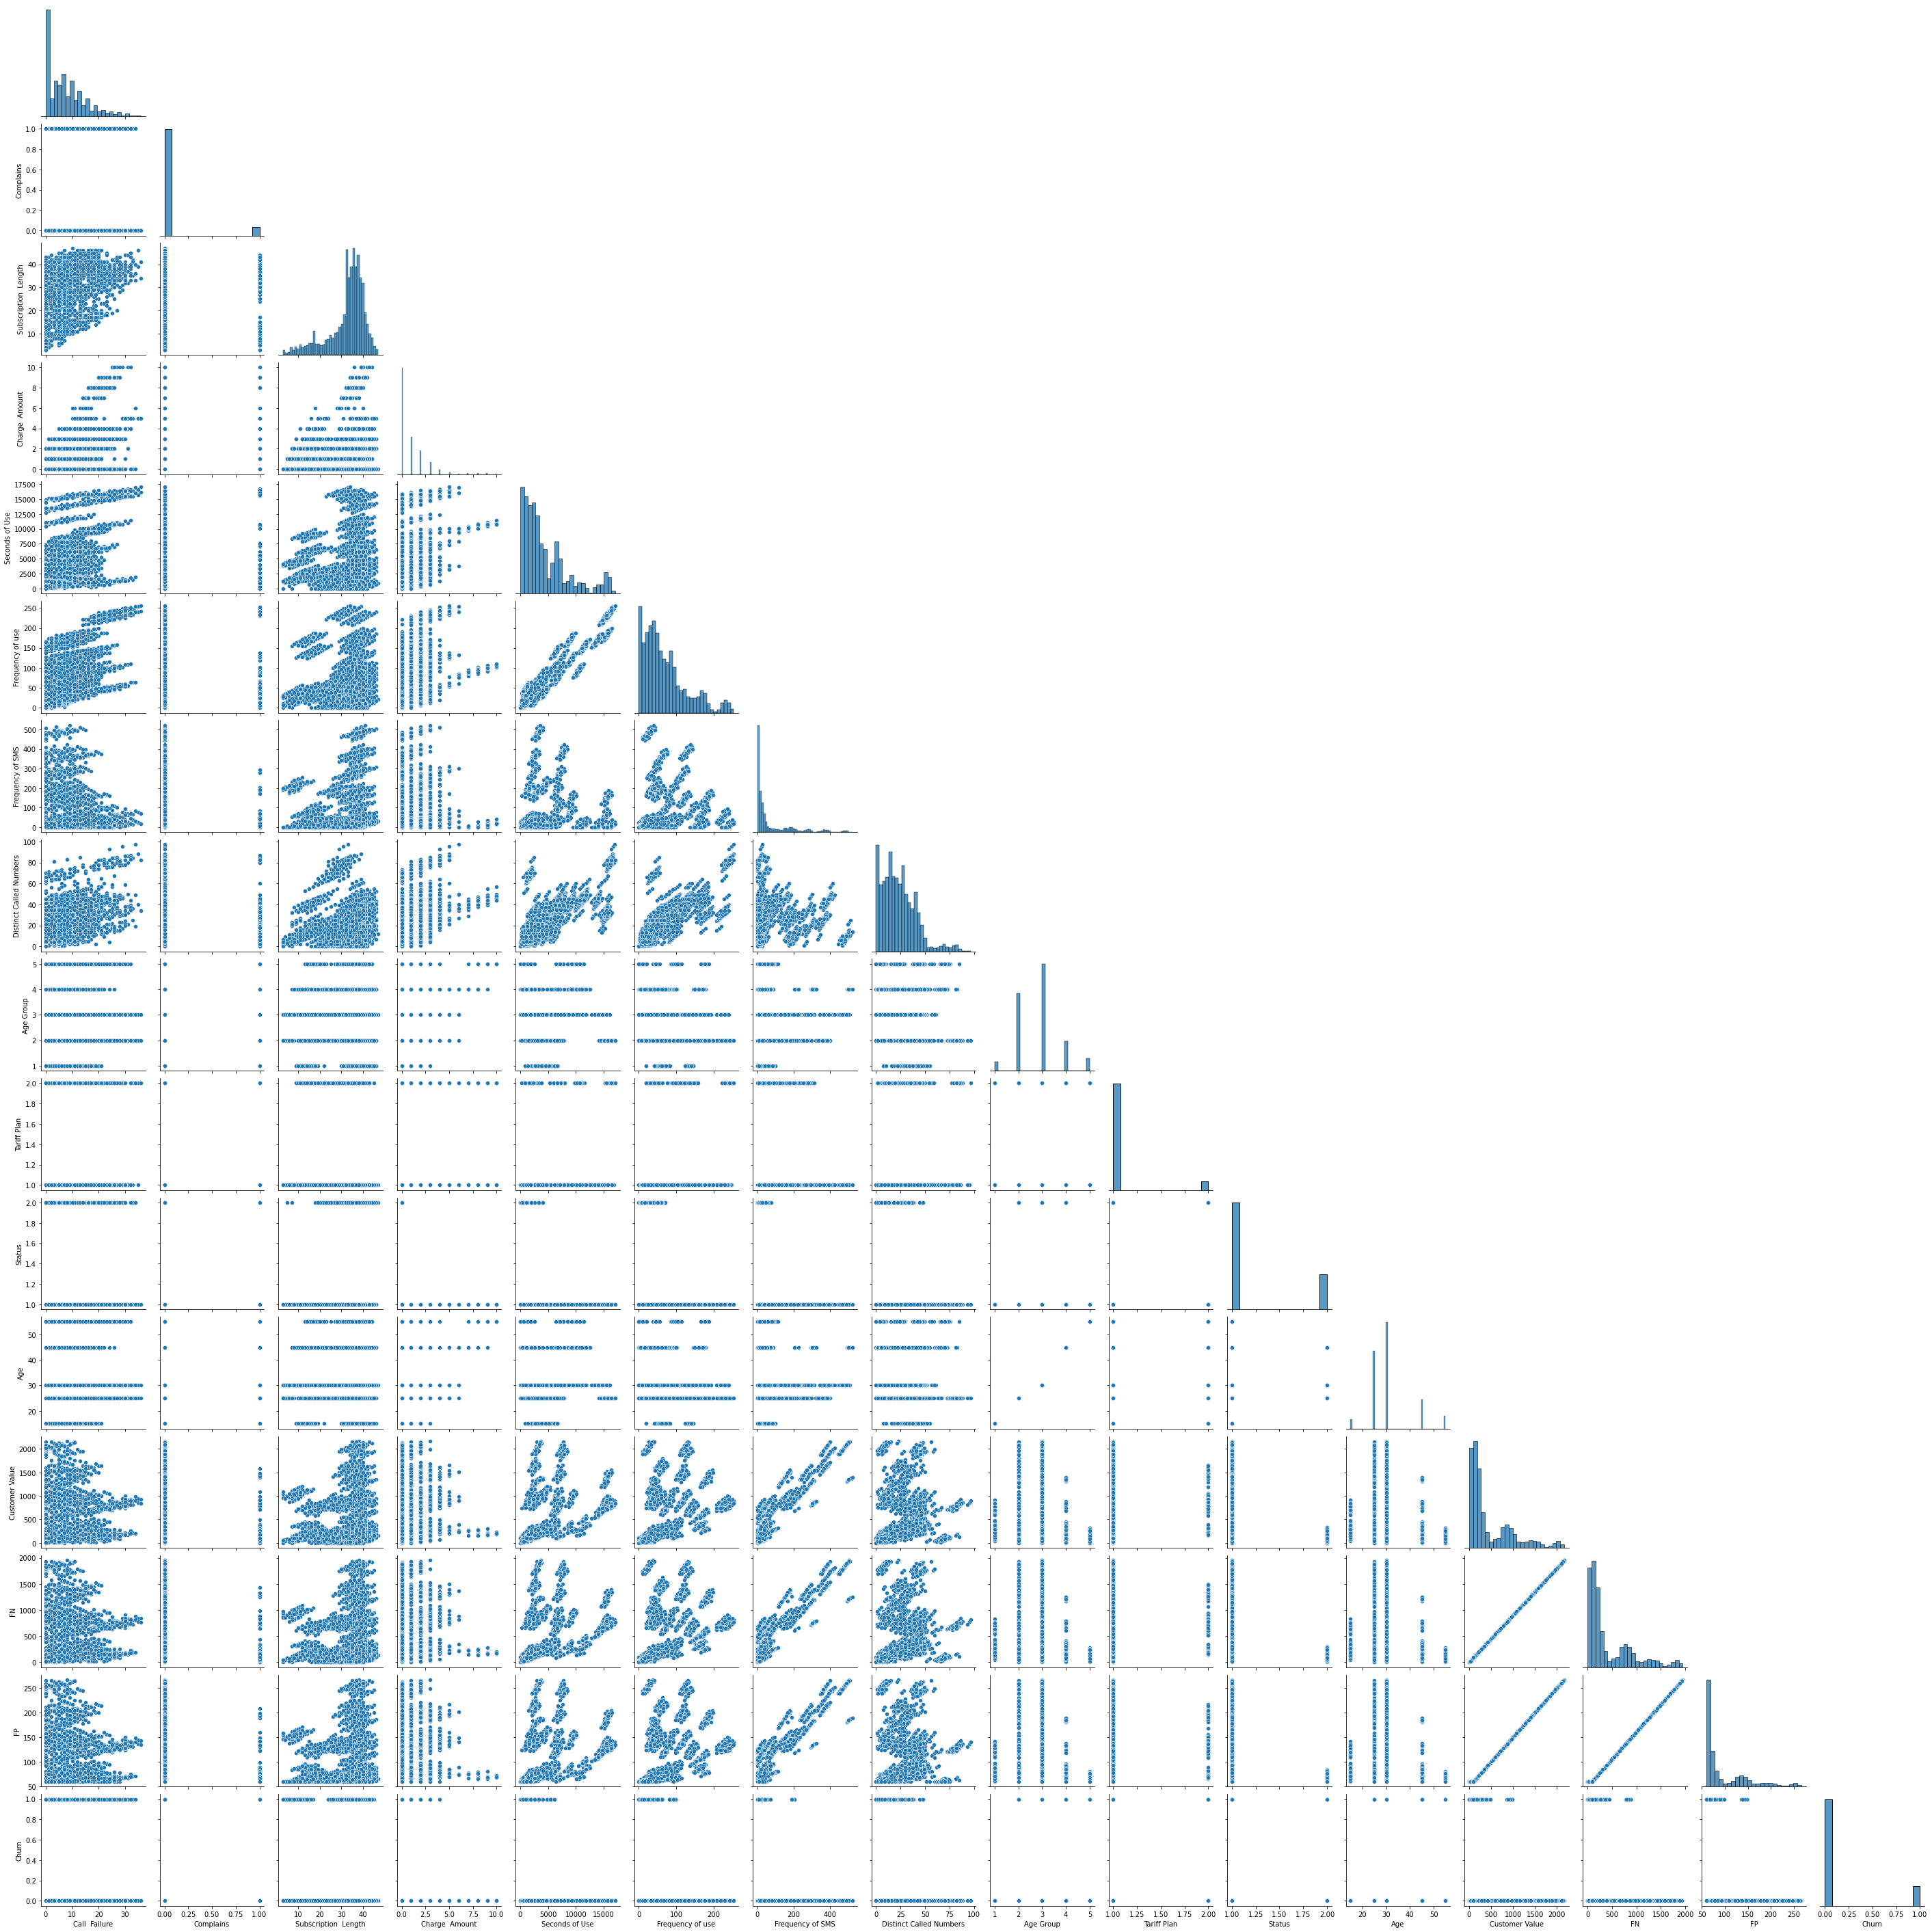

In [16]:
sns.pairplot(churn, corner=True) #hue='age')
            

## Modeling


In [19]:
#Baseline using Churn
churn['Churn'].value_counts(normalize=True) 

0    0.842857
1    0.157143
Name: Churn, dtype: float64

In [24]:
#Baseline check - looking at Status
churn['Status'].value_counts(normalize=True) 

1    0.751746
2    0.248254
Name: Status, dtype: float64

In [20]:
#define X and y
X=churn.drop(['Churn'], axis=1)
y=churn['Churn']

In [21]:
##TTS
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=33)

---
#### LogisticRegression

In [22]:
#LogisticRegression all features
pipe = make_pipeline(StandardScaler(),LogisticRegression(n_jobs=-1))
#
#params = {'countvectorizer__max_features':[500, 1000, 15000, 2000, 2500]}
#
#grid=GridSearchCV(pipe, n_jobs= -1)
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.8920406435224386

In [25]:
pipe.fit(X_test, y_test)
pipe.score(X_test, y_test)

0.8946700507614214

In [26]:
#LogisticRegression with hyperparameters
pipe_lgr = make_pipeline(StandardScaler(), LogisticRegression(n_jobs = -1, max_iter = 1000))
params = {'logisticregression__C' : [0.1, 0.75, 1, 10],
          'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear']}
grid_lgr = GridSearchCV(pipe_lgr, param_grid = params)
grid_lgr.fit(X_train, y_train)
print(f'Train Score: {grid_lgr.score(X_train, y_train)}')
print(f'Test Score: {grid_lgr.score(X_test, y_test)}')
grid_lgr.best_params_


Train Score: 0.8971210838272651
Test Score: 0.8972081218274112


{'logisticregression__C': 0.1, 'logisticregression__solver': 'liblinear'}

---
#### K Nearest Neighbors

In [27]:
#KNN
pipe_knn = make_pipeline(StandardScaler(),KNeighborsClassifier(n_jobs=-1))
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_train, y_train)
print(f'Train Score: {pipe_knn.score(X_train, y_train)}')
print(f'Test Score: {pipe_knn.score(X_test, y_test)}')

Train Score: 0.9627434377646062
Test Score: 0.9543147208121827


In [28]:
#KNN with params
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs = -1))

# n_neighbors must be odd to avoid an even split
#Note: tried leaf size and p, but it didn't give us any value
params = {'kneighborsclassifier__n_neighbors' : [5, 7, 9, 11]}  

grid_knn = GridSearchCV(pipe_knn, param_grid = params)
grid_knn.fit(X_train, y_train)
print(f'Train Score: {grid_knn.score(X_train, y_train)}')
print(f'Test Score: {grid_knn.score(X_test, y_test)}')
grid_knn.best_params_

Train Score: 0.9627434377646062
Test Score: 0.9543147208121827


{'kneighborsclassifier__n_neighbors': 5}

---
#### Random Forest

In [77]:
# Random Forest

pipe_forest = make_pipeline(StandardScaler(), RandomForestClassifier(n_jobs = -1, random_state = 123))

params = {'randomforestclassifier__max_depth' : [6, 7, 8, 9, 10, 11],
          'randomforestclassifier__max_features' : [15, 20, 30, 35]}

grid_forest = GridSearchCV(pipe_forest, param_grid = params)

grid_forest.fit(X_train, y_train)

print(f'Train Score: {grid_forest.score(X_train, y_train)}')
print(f'Test Score: {grid_forest.score(X_test, y_test)}')

grid_forest.best_params_

Train Score: 0.9864521591871296
Test Score: 0.9631979695431472


{'randomforestclassifier__max_depth': 11,
 'randomforestclassifier__max_features': 15}

### Attempt to dive deeper into feature importance

In [34]:
#0 not churn
#1 is churn.  #high  positive coef value means that feature contributes more toward churn (1)#LR > Pipe > Grids

#Steps
#1 get array of featurenames
#2. put them together in dF


grid_lgr.best_estimator_.named_steps['logisticregression'].coef_

array([[ 0.42856585,  0.96851395, -0.19157403, -0.30614125,  0.01026141,
        -0.67658788, -0.34807733, -0.39827574, -0.13659781, -0.12373032,
         0.510483  ,  0.04986073, -0.19330283, -0.19330283,  0.09241848]])

In [43]:
X.columns

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'FN', 'FP'],
      dtype='object')

In [57]:
#names = X.columns
names = X.columns.to_numpy()
coef = grid_lgr.best_estimator_.named_steps['logisticregression'].coef_


In [58]:
type(names)

numpy.ndarray

In [39]:
type(coef)

numpy.ndarray

In [61]:
## merge both series 
#df = pd.merge(names, coef, right_index = True,
#               left_index = True)
## show the dataframe
#df
#


In [60]:
#merged = np.concatenate(names, coef)

TypeError: only integer scalar arrays can be converted to a scalar index

In [65]:

# Create the pandas DataFrame
df = pd.DataFrame(coef, columns = names)
  
# print dataframe.
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP
0,0.428566,0.968514,-0.191574,-0.306141,0.010261,-0.676588,-0.348077,-0.398276,-0.136598,-0.12373,0.510483,0.049861,-0.193303,-0.193303,0.092418


In [74]:
#Show the features in order

df.sort_values(by = 0,axis=1, ascending = False).T


,0
Complains,0.968514
Status,0.510483
Call Failure,0.428566
FP,0.092418
Age,0.049861
Seconds of Use,0.010261
Tariff Plan,-0.123730
Age Group,-0.136598
Subscription Length,-0.191574
Customer Value,-0.193303


__Feature - Coef score__

Score of 0 = not churned
Score of 1 = churned
Higher positive coef scores mean higher contributer to churn score.

* Complains - 0.96851395
* Call Failure - 0.428566
* Charge  Amount - -0.30614125
* Frequency of use - -0.67658788
* Frequency of SMS - -0.34807733
* Distinct Called Numbers - -0.39827574